In [1]:
import sys
import os
import time
import glob
import pickle

sys.path.insert(0,'../')
sys.path.insert(0,'../py')

import parameters
import utilities
from spectrogram_utilities import spectrogram_reshape, spectrogram_plot, spectrogram_hist
import output_utilities
from spectrogram_output_visualiser import spectrogram_cut, spectrogram_cut_augmented

import numpy as np
import pandas as pd
import h5py

from PIL import Image

# tf.enable_eager_execution() 
# tf.logging.set_verbosity(tf.logging.INFO)

In [37]:
def spectrogram_cuts_db(awd_event, site, files, database_name, 
                        threshold=parameters.output_threshold,
                        time_lower_boundary = parameters.time_lower_boundary,
                        time_upper_boundary = parameters.time_upper_boundary,
                        freq_upper_boundary = parameters.freq_upper_boundary,
                        freq_lower_boundary = parameters.freq_lower_boundary,
                        verbose=False, force=False):
    '''Extract the whistler and noise cuts and store them in a h5py database'''
    start = time.time()

    # create h5py database
    if not utilities.init_h5py(database_name, force=force, verbose=verbose):
        return 
    # load database
    database = h5py.File(utilities.get_h5py_path(database_name), 'r+')

    if verbose:
        print('\nGenerating whistler and noise cuts database for %s/%s' %('awdEvent'+str(awd_event),site))
        last_percent = None
        num_file = 0
    for file in files:
        indices, spectrogram, spec_cuts, noise_cuts, f_cut_length, t_cut_length = spectrogram_cut(
            awd_event, site, file, 
            threshold=threshold,
            time_lower_boundary=time_lower_boundary,
            time_upper_boundary=time_upper_boundary,
            freq_upper_boundary=freq_upper_boundary,
            freq_lower_boundary=freq_lower_boundary)
        i = 0
        for cut in spec_cuts:
            spec = spectrogram[cut[0]:cut[1],cut[2]:cut[3]] # extract portion of interest in the spectrogram 
            # resize spec to fixed size
#             spec = Image.fromarray(spec).resize((parameters.clf_input_width, parameters.clf_input_height))
#             spec = np.array(spec)
            spec = spectrogram_reshape(spec)
            dataset_name = file.split(site)[0]+str(i)
            file_dataset = database.create_dataset(dataset_name,spec.shape,np.float32, compression="gzip", data=spec)
            file_dataset.attrs['pb'] = int(indices[i][-1])
            file_dataset.attrs['evt'] = True
            file_dataset.attrs['site'] = site
            i += 1
        for noise in noise_cuts:
            spec = spectrogram[noise[0]:noise[1], noise[2]:noise[3]]
            # resize spec to fixed size
#             spec = Image.fromarray(spec).resize((parameters.clf_input_width, parameters.clf_input_height))
#             spec = np.array(spec)
            spec = spectrogram_reshape(spec)
            dataset_name = file.split(site)[0]+str(i)
            file_dataset = database.create_dataset(dataset_name,spec.shape,np.float32, compression="gzip", data=spec)
            file_dataset.attrs['pb'] = 0
            file_dataset.attrs['evt'] = False
            file_dataset.attrs['site'] = site
            i += 1
        if verbose:
            percent = int(num_file*100/len(files))
            if last_percent != percent:
                if percent%10==0:
                    sys.stdout.write("%s%%" % percent)
                    sys.stdout.flush()
                else:
                    sys.stdout.write(".")
                    sys.stdout.flush()
                last_percent = percent
            num_file+=1
    database.attrs['freq_length']=f_cut_length
    database.attrs['time_length']=t_cut_length
    database.attrs['width']=parameters.clf_input_width
    database.attrs['height']=parameters.clf_input_height
    database.close()
    end = time.time()
    if verbose:
        print("\nRuntime: {:.2f} seconds".format(end - start))

In [38]:
def spectrogram_cuts_augmented_db(awd_event, site, files, database_name, 
                        threshold=parameters.output_threshold,
                        verbose=False, force=False):
    '''Extract the whistler and noise cuts and store them in a h5py database'''
    start = time.time()

    # create h5py database
    if not utilities.init_h5py(database_name, force=force, verbose=verbose):
        return 
    # load database
    database = h5py.File(utilities.get_h5py_path(database_name), 'r+')

    if verbose:
        print('\nGenerating whistler and noise cuts database for %s/%s' %('awdEvent'+str(awd_event),site))
        last_percent = None
        num_file = 0
    for file in files:
        indices, spectrogram, spec_cuts, noise_cuts, f_cut_length, t_cut_length = spectrogram_cut_augmented(
            awd_event, site, file, threshold=threshold)

        i = 0
        for cut in spec_cuts:
            spec = spectrogram[cut[0]:cut[1],cut[2]:cut[3]] # extract portion of interest in the spectrogram 
            # resize spec to fixed size
#             spec = Image.fromarray(spec).resize((parameters.clf_input_width, parameters.clf_input_height))
#             spec = np.array(spec)
            spec = spectrogram_reshape(spec)
            dataset_name = file.split(site)[0]+str(i)
            file_dataset = database.create_dataset(dataset_name,spec.shape,np.float32, compression="gzip", data=spec)
#             file_dataset.attrs['pb'] = int(indices[i][-1])
            file_dataset.attrs['evt'] = True
            file_dataset.attrs['site'] = site
            i += 1
        for noise in noise_cuts:
            spec = spectrogram[noise[0]:noise[1], noise[2]:noise[3]]
            # resize spec to fixed size
#             spec = Image.fromarray(spec).resize((parameters.clf_input_width, parameters.clf_input_height))
#             spec = np.array(spec)
            spec = spectrogram_reshape(spec)
            dataset_name = file.split(site)[0]+str(i)
            file_dataset = database.create_dataset(dataset_name,spec.shape,np.float32, compression="gzip", data=spec)
#             file_dataset.attrs['pb'] = 0
            file_dataset.attrs['evt'] = False
            file_dataset.attrs['site'] = site
            i += 1
        if verbose:
            percent = int(num_file*100/len(files))
            if last_percent != percent:
                if percent%10==0:
                    sys.stdout.write("%s%%" % percent)
                    sys.stdout.flush()
                else:
                    sys.stdout.write(".")
                    sys.stdout.flush()
                last_percent = percent
            num_file+=1
    database.attrs['freq_length']=f_cut_length
    database.attrs['time_length']=t_cut_length
    database.attrs['width']=parameters.clf_input_width
    database.attrs['height']=parameters.clf_input_height
    database.close()
    end = time.time()
    if verbose:
        print("\nRuntime: {:.2f} seconds".format(end - start))

In [39]:
def load_spectrogram_cuts_db(awd_event, site, database_name, verbose=False, noise=True):
    '''Load spectrogram cuts from database
    returns:
        array of spectrogram
    '''
    start = time.time()
    data = []
    pb = []
    evt = []
    _site = []
    # load database
    try:
        database = h5py.File(utilities.get_h5py_path(database_name), 'r+')
    except Exception as e:
        if verbose:
            print(e)
        # if no database, create the database
        files = utilities.all_files(awd_event, site)
        spectrogram_cuts_db(awd_event, site, files, database_name,verbose=verbose)
        start = time.time() # restart timing
        database = h5py.File(utilities.get_h5py_path(database_name), 'r+')
    files = list(database.keys())
    if verbose:
        print('\nLoading spectrogram cuts from database for %s/%s' %('awdEvent'+str(awd_event),site))
        last_percent = None
        num_file = 0
    for file in files:
        if not noise and not database[file].attrs['evt']:
            # if noise is not selected, skip the noise cut
            
            continue
        file_data = np.empty(database[file].shape)
        database[file].read_direct(file_data)
        file_data = file_data.flatten()
        data.append(file_data)
#         pb.append(database[file].attrs['pb'])
        evt.append(database[file].attrs['evt'])
        _site.append(database[file].attrs['site'])
        if verbose:
            percent = int(num_file*100/len(files))
            if last_percent != percent:
                if percent%10==0:
                    sys.stdout.write("%s%%" % percent)
                    sys.stdout.flush()
                else:
                    sys.stdout.write(".")
                    sys.stdout.flush()
                last_percent = percent
            num_file+=1
    data = np.array(data)
    pb = np.array(pb)
    evt = np.array(evt)
    f_cut_length = database.attrs['freq_length']
    t_cut_length = database.attrs['time_length']
    
    database.close()
    end = time.time()
    if verbose:
        print("\nRuntime: {:.2f} seconds".format(end - start))
    return data, pb, evt, f_cut_length, t_cut_length

# Singular H5 file

In [47]:
def spectrogram_cuts_h5py(awd_event, site, augmented=False, verbose=False, 
                              threshold=parameters.output_threshold, 
                              reshape=True, 
                              testing_split=None,
                              zscore=False,
                              method=None,
                              medfilt=False):
    '''Extract the whistler and noise cuts and store them in a h5py database'''
    start = time.time()
    
    files = utilities.all_files(awd_event, site)
    if testing_split is not None and testing_split < 1 and testing_split > 0:
        split_index = int(len(files)*(1-testing_split))
        training_files = files[:split_index]
        testing_files = files[split_index:]
        dic = {"training": training_files,
              "testing": testing_files,
              "split": testing_split}
        pickle.dump( dic, open( os.path.join(parameters.hyp5_location,'awdEvents'+str(awd_event), site,'h5py_cuts','spectrogram_cuts.pickle'), "wb" ) )
    elif testing_split is None:
        training_files = files
        testing_files = None
    else:
        raise Exception('testing_split should be between 1 and 0')
        
    if verbose:
        print('\nGenerating whistler and noise cuts training database for %s/%s' %('awdEvent'+str(awd_event),site))
        last_percent = None
        num_file = 0
    for file in training_files:
        indices, spectrogram, spec_cuts, noise_cuts, f_cut_length, t_cut_length = spectrogram_cut(awd_event, site, file, threshold=threshold, zscore=zscore, medfilt=medfilt, method=method)
        if augmented:
            _indices, _spectrogram, _spec_cuts, _noise_cuts, _f_cut_length, _t_cut_length = spectrogram_cut_augmented(awd_event, site, file, threshold=threshold, zscore=zscore, medfilt=medfilt, method=method)
            spec_cuts = np.append(spec_cuts, _spec_cuts, axis=0)
            noise_cuts = np.append(noise_cuts, _noise_cuts, axis=0)
        i = 1
        try:
            os.makedirs(os.path.join(parameters.hyp5_location,'awdEvents'+str(awd_event), site,'h5py_cuts','training'))
        except OSError:
            pass
        for cut in spec_cuts:
            spec = spectrogram[cut[0]:cut[1],cut[2]:cut[3]] # extract portion of interest in the spectrogram 
            if reshape:
                spec = spectrogram_reshape(spec)
            dataset_name = os.path.join(parameters.hyp5_location,
                                        'awdEvents'+str(awd_event), site,
                                        'h5py_cuts','training',
                                os.path.splitext(file)[0]+'.cut_'+str(i)+'_1'+'_'+str(cut[0])+'_'+str(cut[1])+'_'+str(cut[2])+'_'+str(cut[3])+'.h5')
            f = h5py.File(dataset_name, 'w')
            file_dataset = f.create_dataset(dataset_name,spec.shape,np.float32, compression="gzip", data=spec)
            file_dataset.attrs['evt'] = True
            f.close()
            i += 1
        for noise in noise_cuts:
            spec = spectrogram[noise[0]:noise[1], noise[2]:noise[3]]
            if reshape:
                spec = spectrogram_reshape(spec)
            dataset_name = os.path.join(parameters.hyp5_location,
                                        'awdEvents'+str(awd_event),site,
                                        'h5py_cuts','training',
                                os.path.splitext(file)[0]+'.cut_'+str(i)+'_0'+'_'+str(cut[0])+'_'+str(cut[1])+'_'+str(cut[2])+'_'+str(cut[3])+'.h5')
            f = h5py.File(dataset_name, 'w')
            file_dataset = f.create_dataset(dataset_name,spec.shape,np.float32, compression="gzip", data=spec)
            file_dataset.attrs['evt'] = False
            f.close()
            i += 1
        if verbose:
            percent = int(num_file*100/len(training_files))
            if last_percent != percent:
                if percent%10==0:
                    sys.stdout.write("%s%%" % percent)
                    sys.stdout.flush()
                else:
                    sys.stdout.write(".")
                    sys.stdout.flush()
                last_percent = percent
            num_file+=1
    if testing_files is not None:
        if verbose:
            print('\nGenerating whistler and noise cuts testing database for %s/%s' %('awdEvent'+str(awd_event),site))
            last_percent = None
            num_file = 0
        for file in testing_files:
            indices, spectrogram, spec_cuts, noise_cuts, f_cut_length, t_cut_length = spectrogram_cut(awd_event, site, file, threshold=threshold)
            if augmented:
                _indices, _spectrogram, _spec_cuts, _noise_cuts, _f_cut_length, _t_cut_length = spectrogram_cut_augmented(awd_event, site, file, threshold=threshold)
                spec_cuts = np.append(spec_cuts, _spec_cuts, axis=0)
                noise_cuts = np.append(noise_cuts, _noise_cuts, axis=0)
            i = 1
            try:
                os.makedirs(os.path.join(parameters.hyp5_location,'awdEvents'+str(awd_event), site,'h5py_cuts','testing'))
            except OSError:
                pass
            for cut in spec_cuts:
                spec = spectrogram[cut[0]:cut[1],cut[2]:cut[3]] # extract portion of interest in the spectrogram 
                if reshape:
                    spec = spectrogram_reshape(spec)
                dataset_name = os.path.join(parameters.hyp5_location,
                                            'awdEvents'+str(awd_event), site,
                                            'h5py_cuts','testing',
                                    os.path.splitext(file)[0]+'.cut_'+str(i)+'_1'+'_'+str(cut[0])+'_'+str(cut[1])+'_'+str(cut[2])+'_'+str(cut[3])+'.h5')
                f = h5py.File(dataset_name, 'w')
                file_dataset = f.create_dataset(dataset_name,spec.shape,np.float32, compression="gzip", data=spec)
                file_dataset.attrs['evt'] = True
                f.close()
                i += 1
            for noise in noise_cuts:
                spec = spectrogram[noise[0]:noise[1], noise[2]:noise[3]]
                if reshape:
                    spec = spectrogram_reshape(spec)
                dataset_name = os.path.join(parameters.hyp5_location,
                                            'awdEvents'+str(awd_event),site,
                                            'h5py_cuts','testing',
                                    os.path.splitext(file)[0]+'.cut_'+str(i)+'_0'+'_'+str(cut[0])+'_'+str(cut[1])+'_'+str(cut[2])+'_'+str(cut[3])+'.h5')
                f = h5py.File(dataset_name, 'w')
                file_dataset = f.create_dataset(dataset_name,spec.shape,np.float32, compression="gzip", data=spec)
                file_dataset.attrs['evt'] = False
                f.close()
                i += 1
            if verbose:
                percent = int(num_file*100/len(testing_files))
                if last_percent != percent:
                    if percent%10==0:
                        sys.stdout.write("%s%%" % percent)
                        sys.stdout.flush()
                    else:
                        sys.stdout.write(".")
                        sys.stdout.flush()
                    last_percent = percent
                num_file+=1
    end = time.time()
    if verbose:
        print("\nRuntime: {:.2f} seconds".format(end - start))

In [5]:
def load_spectrogram_cuts_h5py(awd_event, site, partition="training", verbose=False):
    '''Load spectrogram cuts from database
    returns:
        array of spectrogram
    '''
    start = time.time()
    data = []
    pb = []
    evt = []
    _site = []
    database_location = os.path.join(parameters.hyp5_location,'awdEvents'+str(awd_event), site,'h5py_cuts',partition)
    
    # load all files
    if verbose:
        print('\nLoading spectrogram cuts from %s database for %s/%s' %(partition, 'awdEvent'+str(awd_event),site))
        last_percent = None
        num_file = 0
    files = glob.glob(os.path.join(database_location, '*.h5'))
    for file in files:
        database_file = h5py.File(file, 'r+')
        file_data = np.empty(database_file[file].shape)
        database_file[file].read_direct(file_data)
        data.append(file_data)
        evt.append(database_file[file].attrs['evt'])
        database_file.close()
        if verbose:
            percent = int(num_file*100/len(files))
            if last_percent != percent:
                if percent%10==0:
                    sys.stdout.write("%s%%" % percent)
                    sys.stdout.flush()
                else:
                    sys.stdout.write(".")
                    sys.stdout.flush()
                last_percent = percent
            num_file+=1
    data = np.array(data)
    evt = np.array(evt)


    end = time.time()
    if verbose:
        print("\nRuntime: {:.2f} seconds".format(end - start))
    return data, evt

In [6]:
# awd_event = 1
# site = parameters.sites[0]
# training_data, training_evt = load_spectrogram_cuts_h5py(awd_event, site, verbose=True)
# testing_data, testing_evt = load_spectrogram_cuts_h5py(awd_event, site, partition='testing', verbose=True)


Loading spectrogram cuts from training database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 25.11 seconds

Loading spectrogram cuts from testing database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 9.90 seconds


True


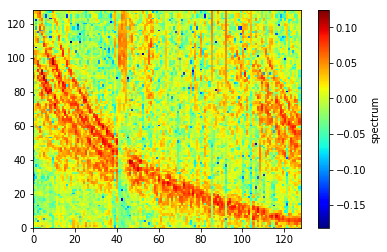

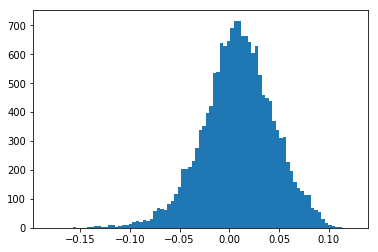

In [19]:
# k = np.random.randint(len(training_data))
# print(training_evt[k])
# spectrogram_plot(training_data[k], xlabel=training_evt[k])
# spectrogram_hist(training_data[k])

## TFRecords

In [31]:
def spectrogram_cuts_tfrecords(awd_event, site,verbose=False):
    '''Extract the whistler and noise cuts and store them in a TFRecords database'''
    start = time.time()
    files = utilities.all_files(awd_event, site)
    if verbose:
        print('\nGenerating whistler and noise cuts tfrecord files for %s/%s' %('awdEvent'+str(awd_event),site))
        last_percent = None
        num_file = 0
    for file in files:
        indices, spectrogram, spec_cuts, noise_cuts, f_cut_length, t_cut_length = spectrogram_output_visualiser.spectrogram_cut(awd_event, site, file, parameters.output_threshold)
        i = 0
        for cut in spec_cuts:
            spec = spectrogram[cut[0]:cut[1],cut[2]:cut[3]] # extract portion of interest in the spectrogram 
            dataset_name = os.path.join(parameters.tfrecord_location,
                                        'awdEvents1',
                                        'cuts',
                                os.path.splitext(file)[0]+'.1'+'_'+str(cut[0])+'_'+str(cut[1])+'_'+str(cut[2])+'_'+str(cut[3])+'.tfr')
            # save whistler cut as a tf record
            writer = tf.python_io.TFRecordWriter(dataset_name)
            feature = {
                'data': tf.train.Feature(
                            float_list=tf.train.FloatList(value=spec.flatten())),
                'merit': tf.train.Feature(
                            int64_list=tf.train.Int64List(value=[int(indices[i][-1])])),
                'label': tf.train.Feature(
                            int64_list=tf.train.Int64List(value=[True]))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # serialize to string and write on the file
            writer.write(example.SerializeToString())
            writer.close()
            i += 1
        for cut in noise_cuts:
            spec = spectrogram[cut[0]:cut[1],cut[2]:cut[3]]
            dataset_name = os.path.join(parameters.tfrecord_location,
                                        'awdEvents1',
                                        'cuts',
                                os.path.splitext(file)[0]+'.0'+'_'+str(cut[0])+'_'+str(cut[1])+'_'+str(cut[2])+'_'+str(cut[3])+'.tfr')
#             print(dataset_name)
            # save noise cut as a tf record
            writer = tf.python_io.TFRecordWriter(dataset_name)
            feature = {
                'data': tf.train.Feature(
                            float_list=tf.train.FloatList(value=spec.flatten())),
                'merit': tf.train.Feature(
                            int64_list=tf.train.Int64List(value=[0])),
                'label': tf.train.Feature(
                            int64_list=tf.train.Int64List(value=[False]))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # serialize to string and write on the file
            writer.write(example.SerializeToString())
            writer.close()
            i += 1
        if verbose:
            percent = int(num_file*100/len(files))
            if last_percent != percent:
                if percent%10==0:
                    sys.stdout.write("%s%%" % percent)
                    sys.stdout.flush()
                else:
                    sys.stdout.write(".")
                    sys.stdout.flush()
                last_percent = percent
            num_file+=1
    end = time.time()
    if verbose:
        print("\nRuntime: {:.2f} seconds".format(end - start))